# The problem

The company that I'm currently working at (its name is irrelevant as you'll see in a moment) is in the middle of a rebrading effort. One of the key components in this is finding a better name for the company!

The marketing department outlined a few likeliness topic to which the name should be associated with:
* Mythology
* Science
* Succesfull organisation
* AI

The name should also be trademark-able and it's domains should be available for registration.

With this knowledge in hand I've set out to conquer the challenge!

**I'm going to build an ML system that would generate the future name for our company!**

## Problem analisys

The above forumulation needs a few clarifications (added by me) that would make the problem more specific:
* We'll build an ML system that generates company names
    * This alone will cover for the "AI association" requirement
    
* The geneated names should be:
    * similar in style as to the following topics:
        * Mythology
        * Science
        * Tech unicorn companies
        * Fiction
    * Plausible company names

* The generated names should be unique (not duplicates of the training data)
* The generated names should have an unregisterd .com domain
* Given that this is a branding execise, marketing should have control over the stucture of the following name generation aspects:
    * Length of the name
    * Inclusion of specific sub string within the name
    * Starting first letter of the name

## Data sources

To start off, we need names datasets for the following topics and I've settled for some quick proxies:
* Mythology - all Roman and Greek mythological figures as extracted from [here](https://www.npmjs.com/package/greek-mythology-data)
* Science - all animals and birds names as extracted from [here](https://github.com/species-names)
* Tech unicorn companies - took the [organisations and companies](https://www.kaggle.com/kaggle/meta-kaggle#Organizations.csv) that submitted Kaggle competitions. Presumably these are current or future unicorns.
* Fiction - all the Lord Of The Rings [characters](https://www.kaggle.com/mokosan/lord-of-the-rings-character-data/version/1)

Because I want the generated names to also resemble some usual company names, and given the assumption that `most of these have names derived from familly names` (e.g. "Johnson & Johnson", "Calvin Klein", "Merrill Lynch", etc..) I've took the [US Census familly name dataset](http://www2.census.gov/topics/genealogy/1990surnames/dist.all.last) to augment the above datasets. 

# Loading the data

Having these datasets, I'll load them with pandas and show and show the first few of each.

In [274]:
import pandas as pd
animals = pd.read_csv("animals.csv", header=None, comment='#', names=["Animals"])
animals.head()

,Animals
0,Abderites
1,Acinonyx
2,Acomys
3,Acratocnus
4,Addax


In [4]:
familly_names = pd.read_csv("familly_names.csv", header=None, comment='#', names=["Surnames"])
familly_names.head()

,Surnames
0,Smith
1,Johnson
2,Williams
3,Jones
4,Brown


In [5]:
birds = pd.read_csv("birds.csv", header=None, comment='#', names=["Birds"])
birds.head()

,Birds
0,Abeillia
1,Abroscopus
2,Aburria
3,Acanthagenys
4,Acanthidops


In [6]:
mythology = pd.read_csv("mythology.csv", header=None, comment='#', names=["Mythology"])
mythology.head()

,Mythology
0,Calleis
1,Epirus
2,Harpocrates
3,Xanthus
4,Stilbon


In [7]:
organisations = pd.read_csv("kaggle_organisations.csv", header=None, comment='#', sep="\n", names=["Organisations"])
organisations.head()

,Organisations
0,Facebook
1,Figure Eight
2,Kaggle
3,Last-Place Ltd.
4,CWILOC


In [275]:
lotr = pd.read_csv("lotr_names.csv", header=None, comment='#', names=["LOTR"])
lotr.head()

,LOTR
0,Aragorn Ii
1,Arwen
2,Elrond
3,Celebrían
4,Elrohir


In [278]:
pd.concat([birds, animals, mythology, familly_names, organisations, lotr], axis=1).head()

,Birds,Animals,Mythology,Surnames,Organisations,LOTR
0,Abeillia,Abderites,Calleis,Smith,Facebook,Aragorn Ii
1,Abroscopus,Acinonyx,Epirus,Johnson,Figure Eight,Arwen
2,Aburria,Acomys,Harpocrates,Williams,Kaggle,Elrond
3,Acanthagenys,Acratocnus,Xanthus,Jones,Last-Place Ltd.,Celebrían
4,Acanthidops,Addax,Stilbon,Brown,CWILOC,Elrohir


Ok, everything look nice!

# Understanding the data

Before training anything we need to make sure we understand our data. 

## Making a balanced dataset

First off is to see how many names in each category do we have. This is important because if one of them is way larger than the others it would skew the ML model to generate data that resembles that at the expense of the other categories.

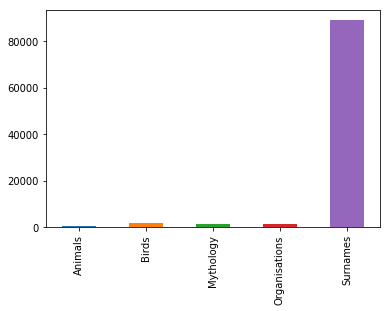

In [48]:
import numpy as np
everything = pd.concat([animals, birds, mythology, organisations, familly_names], axis=1)
everything.count().plot(kind='bar')

It's evident from the above graph that the familly names datases is way larger than the other ones. We don't want it to be more represented than the other categories.

We're going to compute the median of all the counts. This value will tell us how many samples to take from each category and is a middle ground between the ones that have few names and the ones that have lots of names.

In [9]:
median = int(np.median((len(animals), len(birds), len(mythology), len(organisations), len(familly_names))))
median

1588

Because some collections have fewer than `median` elements, we need to sample with `replace=True` (this will add duplicates). In this step we'll also concatenate everything into one large dataset.

In [279]:
all_names = np.concatenate((
    animals.sample(n=median, replace=True),
    birds.sample(n=median, replace=True),
    mythology.sample(n=median, replace=True),
    organisations.sample(n=median, replace=True),
    familly_names.sample(n=median, replace=True),
    lotr.sample(n=median, replace=True),
))
all_names.shape

(9528, 1)

Great! 10k names isn't that bad!

Some examples of the resulting data.

In [12]:
all_names[90:100]

array([['Thylacoleo'],
       ['Odocoileus'],
       ['Liberiictis'],
       ['Carpitalpa'],
       ['Hesperaletes'],
       ['Cricetomys'],
       ['Chrotopterus'],
       ['Thylacoleo'],
       ['Macrogalidia'],
       ['Kenyatherium']], dtype=object)

## Eliminating lengthy outliers 

It's possible that our names dataset contain some really large, lengthy names. And it's almost certain that these will be outliers for the full data. If this is the case, we'll need to eliminate them and only deal with the common average names.

We'll printing a name length statistics to see how lengths are represented in the dataset.

In [280]:
length_pd = pd.DataFrame([[len(name), name] for [name] in all_names], columns=["Length", "Name"])
length_pd.head()

,Length,Name
0,11,Podogymnura
1,9,Myotragus
2,12,Balaenoptera
3,9,Pseudorca
4,8,Nurocyon


The outliers that we're seeking should be in the high percentiles, so we'll print the pandas statistics of the DataFrame adding those percentiles as well. By default, pandas only includes the `[.25, .50, .75]` percentiles.

In [281]:
length_pd.describe(percentiles=[.90, .95, .99])

,Length
count,9528.000000
mean,10.419395
std,51.586712
min,2.000000
50%,8.000000
90%,14.000000
95%,17.000000
99%,32.000000
max,2859.000000


So 99% of the data has less than 33 chars, but the maximum name in it is 2859 chars! We should actually see what's with this large name and find out how many of these we have.

In [283]:
np.sort(length_pd.Length.unique())

array([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,   12,
         13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
         35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,
         46,   47,   48,   49,   50,  209,  595, 2859])

So we have some `{209, 595, 2859}` names. The rest of the buckets seem to be in a reasonable range. What are these large names?

In [285]:
[name for [name] in all_names if len(name) in {209, 595, 2859}]

["/><h1>test</h1>\nMindMatch\nData Unicorns\nmyOrganization\nInfosys\nRain City Casual\nOnkar Kadam\nMayflower\nhttp://humbertobrandao.com\nwecash\nQueen's Centre for Advanced Computing\npapuuuus\nVinayagam\n</title>A'><h1>X",
 "/><h1>test</h1>\nMindMatch\nData Unicorns\nmyOrganization\nInfosys\nRain City Casual\nOnkar Kadam\nMayflower\nhttp://humbertobrandao.com\nwecash\nQueen's Centre for Advanced Computing\npapuuuus\nVinayagam\n</title>A'><h1>X"]

To me, these look like SQL Injection attempts on the Kaggle web-site.. I hope Kaggle fought them off. But the overall conclusion is that the bad apples come from the Kaggle organisations dataset. 

I'm unsure if we should spend more time cleaning the organisation names, but just to keep it simple, maybe we should drop the organisations, they seem the contain lots of noise.

In [286]:
all_names = np.concatenate((
    animals.sample(n=median, replace=True),
    birds.sample(n=median, replace=True),
    mythology.sample(n=median, replace=True),
    familly_names.sample(n=median, replace=True),
    lotr.sample(n=median, replace=True),
))
all_names.shape

(7940, 1)

Printing again the Length percentiles..

In [287]:
length_pd = pd.DataFrame([[len(name), name] for [name] in all_names], columns=["Length", "Name"])
length_pd.describe(percentiles=[.90, .95, .99])

,Length
count,7940.000000
mean,8.462469
std,2.901147
min,3.000000
50%,8.000000
90%,12.000000
95%,14.000000
99%,17.000000
max,24.000000


Ok, the maximum name now is 24 chars long. I wonder what that is?

In [288]:
max_length, name = max([len(name), name] for [name] in all_names)
max_length, name

(24, 'The Nymphai Hyperboreioi')

Seems more reasonable now!

# Vocabulary

The model I'm building (as any other model) should receive numerical data, so we need a way to convert the strings to numerical representations. 

Usually this is done by a two-way datastructure that returns an unique id for a given char, and a char for a given id. 

This datastructure is called a vocabulary and we can quickly simulate one by using a list and a dictionary both synced on the same ids. 

In the vocabulary we will also need (at least) two special characters:
* `PADD_CHAR` that will be used to convert inputs that are smaller than the fixed length required by a model
* `STOP_CHAR` that will mark the end of a name

There are other additional specials that you could add but this is beiond the point of this excercise.

In [289]:
STOP_CHAR = '|'
PADD_CHAR = '_'
id2voc = np.array([STOP_CHAR, PADD_CHAR] + list({char for [name] in all_names for char in name}))
voc2id = {char: i for i, char in enumerate(id2voc)}
voc_size = len(id2voc)
voc_size, id2voc

(76, array(['|', '_', 'ï', 'i', 'g', 'n', 'S', 'h', 'G', 'M', 'm', 'B', 's',
        'w', 'ä', 'â', 'ê', "'", 'E', 'o', 'O', 'Î', 'Í', 'N', 'û', '\xad',
        'd', 'H', 'b', 'V', 'R', 'Z', 'ë', 'í', 'C', 'D', 'ó', 'a', 'z',
        'f', 'r', 'T', 'K', 'c', 'ö', 'É', 'k', 'j', 'l', 'ú', 'e', 'y',
        'Y', 'A', 'W', 'X', 'x', 'P', 'é', 'Ó', '-', 'J', 'ô', 'v', 'Q',
        ' ', '.', 'I', 'á', 'F', 'U', 'u', 'q', 'p', 'L', 't'], dtype='<U1'))

# Model

## Model idea

I will model the task as a prediction (classification to be more exact) problem, where given as input a sequence of n characters `[c1, c2, c3, .., c(n) ]` the aim of the model is to predict the next *plausible* character `c(n+1)`.

For example if I have the following input: `Mari` the model should be able to predict that the next most probabile character is `a`. 

In this case, `n` will be called a `window_size` because we will treat each name in the training set as a sequence over which we will be sliding a moving window, treating the window contents as the input and the next char, comming right after the window, the target prediction.

For example `Lochmias` will have the following windows and predictions:

```inp y
......
   L o
  Lo c
 Loc h
Loch m
ochm i
chmi a
hmia s```

## Model implementation

I'm going to use keras as is fast and eloquent.

In [15]:
import keras
from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense, Embedding
from keras.models import Model

Using TensorFlow backend.


I'm going to stick with a window size of 4 but this is something of a guess-timate and can be tunned.

In [16]:
window_size = 4

I'm not going to talk much about the model bellow as I guess most of the people comming here either understand what's happening already or the opposite, don't care about these.

Suffice to say it's a character level, embeddings enabled RNN model.

In [29]:
inp = Input(shape=(window_size,))
emb = Embedding(input_dim=voc_size, output_dim=50)

x = emb(inp)
x = Bidirectional(LSTM(30, return_sequences=True))(x)
x = Bidirectional(LSTM(30, return_sequences=False))(x)
x = Dropout(0.3)(x)
x = Dense(voc_size)(x)
out = x

model = Model(inputs=[inp], outputs=[out])
model.summary()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 4, 50)             2950      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 4, 60)             19440     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 60)                21840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 59)                3599      
Total params: 47,829
Trainable params: 47,829
Non-trainable params: 0
_________________________________________________________________


# Training data

Once everything is in place we could ideally proceed to the training phase but there's an additional step before that which is massaging the names dataset into the exact format that we need. 

## Splitting the data

First of all is to have a propper `train, validation, test` split (with initial shuffling).

We're going to split the data into 70% 15% 15% for each of the above.

In [20]:
size = len(all_names)
perm = np.random.permutation(size)
train = all_names[perm][:int(size*0.70)]
valid = all_names[perm][int(size*0.70): int(size*0.85)]
test = all_names[perm][int(size*0.85):]

## Creating the data generators.

Keras also needs data either in a list format or a generator that can yield batches of data one at a time. 

Either way, bellow you'll find lots of boiler plate code that may not look so interesting so feel free to skip righ to the `Train` section.

In [21]:
# https://gist.github.com/codehacken/708f19ae746784cef6e68b037af65788
def rolling_window(a, window, step_size):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1 - step_size, window)
    strides = a.strides + (a.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

rolling_window(np.arange(10), 3, 1)

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8]])

In [22]:
left_pad = [PADD_CHAR] * (window_size - 1) 
right_pad = [STOP_CHAR]

def index(this_name):
    return np.array([voc2id[char] for char in this_name])

def window_name(name, window_size):
    this_name = left_pad + list(name) + right_pad
    iname = index(this_name)
    windows = rolling_window(iname, window_size, 1)
    y = np.array([iname[i] for i in range(window_size,len(iname))])
    return windows, y
    
def convert(windows, y):
    for i, wind in enumerate(windows):
        print("".join([id2voc[id] for id in wind]), id2voc[y[i]])
    
train[0][0], convert(*window_name(train[0][0], window_size))

___L o
__Lo c
_Loc h
Loch m
ochm i
chmi a
hmia s
mias |


('Lochmias', None)

In [23]:
from itertools import chain

def loop(iterable, epochs):
    def gen(l):
        for element in l:
            yield element

    return chain(*([gen(iterable) for _ in range(epochs)]))

data = loop([1, 2, 3], 3)
[next(data) for _ in range(8)]

[1, 2, 3, 1, 2, 3, 1, 2]

In [24]:
def generate_batch(names_gen, batch_size=64, n=None, window_size=4):
    x_batch, y_batch = None, None
    for [name] in names_gen:
        windows, y = window_name(name, window_size)
        assert y[-1] == 0
        if x_batch is None:
            x_batch = windows
            y_batch = y
        else:
            x_batch = np.concatenate((
                x_batch, 
                windows
            ))
            y_batch = np.concatenate((
                y_batch,
                y
            ))
        
        while x_batch is not None and len(x_batch) >= batch_size:
            if len(x_batch) > batch_size:
                # with spill-over
                yield x_batch[:batch_size], y_batch[:batch_size]
                x_batch, y_batch = x_batch[batch_size:], y_batch[batch_size:]
            elif len(x_batch) == batch_size:
                # complete name fits in current batch
                yield x_batch, y_batch
                x_batch, y_batch = None, None
        
    
g = generate_batch(train[:10], batch_size=4, n=10)

[sum(y==0) for x, y in g]

[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]

In [25]:
def generator(_data, epochs=1, batch_size=64):
    n = len(_data)
    return generate_batch(loop(_data, epochs=epochs), batch_size=batch_size, n=None)


data = list(generator(train, epochs=1, batch_size=64))
data[:10]

[(array([[ 1,  1,  1, 57],
         [ 1,  1, 57, 15],
         [ 1, 57, 15, 56],
         [57, 15, 56,  6],
         [15, 56,  6,  9],
         [56,  6,  9,  2],
         [ 6,  9,  2, 28],
         [ 9,  2, 28, 10],
         [ 1,  1,  1, 45],
         [ 1,  1, 45,  6],
         [ 1, 45,  6,  2],
         [45,  6,  2, 37],
         [ 6,  2, 37, 28],
         [ 2, 37, 28,  4],
         [37, 28,  4, 58],
         [28,  4, 58, 15],
         [ 4, 58, 15,  9],
         [58, 15,  9, 19],
         [15,  9, 19, 28],
         [ 1,  1,  1, 20],
         [ 1,  1, 20, 38],
         [ 1, 20, 38,  9],
         [20, 38,  9,  2],
         [38,  9,  2,  3],
         [ 9,  2,  3,  4],
         [ 2,  3,  4, 28],
         [ 3,  4, 28, 58],
         [ 4, 28, 58,  6],
         [28, 58,  6, 54],
         [58,  6, 54, 10],
         [ 1,  1,  1, 25],
         [ 1,  1, 25, 28],
         [ 1, 25, 28, 37],
         [25, 28, 37, 28],
         [28, 37, 28,  4],
         [37, 28,  4, 18],
         [28,  4, 18, 31],
 

In [26]:
def step_per_epoch(sequence, batch_size):
    lengths = np.array([len(name[0]) for name in sequence])
    return (sum(lengths) // batch_size) - 1

from functools import reduce
data = train[:100]
batch_size = 6

for i, (x, y) in enumerate(generator(data, epochs=1, batch_size=batch_size)):
    pass

i, step_per_epoch(data, batch_size=batch_size)

(132, 132)

# Train

Everything is in place, so we can start the training!

I'm going to monitor the progress of how the training is progressing by using the validation data.

I'm also run the training for 50 epochs.

In [30]:
epochs = 50
batch_size = 64

training = generator(train, epochs=epochs, batch_size=batch_size)
training_steps = step_per_epoch(train, batch_size)

validate = generator(valid, epochs=epochs, batch_size=batch_size)
validate_steps = step_per_epoch(valid, batch_size)

model.fit_generator(
    training,
    epochs=epochs,
    steps_per_epoch=training_steps,
    validation_data=validate, 
    validation_steps=validate_steps
)

Epoch 1/50
586/586 [==============================] - 13s 22ms/step - loss: 3.2588 - acc: 0.1383 - val_loss: 3.2023 - val_acc: 0.0851
Epoch 2/50
586/586 [==============================] - 9s 16ms/step - loss: 3.0574 - acc: 0.1389 - val_loss: 3.0157 - val_acc: 0.1721
Epoch 3/50
586/586 [==============================] - 10s 16ms/step - loss: 2.9690 - acc: 0.1778 - val_loss: 2.9072 - val_acc: 0.1917
Epoch 4/50
586/586 [==============================] - 10s 17ms/step - loss: 2.9285 - acc: 0.1752 - val_loss: 2.8376 - val_acc: 0.1632
Epoch 5/50
586/586 [==============================] - 10s 17ms/step - loss: 2.8646 - acc: 0.1982 - val_loss: 2.7714 - val_acc: 0.2011
Epoch 6/50
586/586 [==============================] - 10s 17ms/step - loss: 2.9076 - acc: 0.1775 - val_loss: 2.8077 - val_acc: 0.2022
Epoch 7/50
586/586 [==============================] - 11s 18ms/step - loss: 2.8963 - acc: 0.1906 - val_loss: 2.7795 - val_acc: 0.2019
Epoch 8/50
586/586 [==============================] - 11s 18ms/

Now you might argue that 25% accuracy on predicting the next char is not that great but if you consider that this next char is predicted only by looking at the last 4 chars in the word and it can choose among 75 other characters, 25% looks decent enough!

# Predicting

I'm going to start by using a single starting char, padd it with 3 PADD_CHARs and feed it to the model. 

In [41]:
seed = index([PADD_CHAR]*3 + list('B')).tolist()
seed

[1, 1, 1, 11]

Let's see the predictions that we geet..

In [42]:
p = model.predict(np.array([seed[-window_size:]]))
p 

array([[-0.6201387 , -0.23826784,  0.5983277 , -0.10556627, -0.32646263,
        -0.27480856,  0.12557875, -0.3414145 , -0.30603564, -0.06175375,
        -0.35096955, -0.2666734 , -0.32480827, -0.25640425, -0.3097351 ,
         1.0732597 , -0.27867168, -0.26669377, -0.2104237 , -0.08998151,
        -0.32091066, -0.289114  , -0.28993937, -0.33924183, -0.32892138,
        -0.2670479 , -0.38872594, -0.34774324,  1.4566476 , -0.11276225,
        -0.19450927,  0.52868104, -0.3415661 , -0.29098564, -0.24209084,
        -0.2599065 , -0.29484534,  0.37383062,  1.15111   ,  0.33651325,
        -0.28981203, -0.24725765, -0.3549461 , -0.35660768, -0.2112373 ,
        -0.28135416, -0.17757761, -0.30440184, -0.27851555, -0.27763483,
        -0.3249073 , -0.32023948, -0.27075848, -0.27509457,  0.48936015,
        -0.3275905 , -0.08906301, -0.28713107, -0.10081338]],
      dtype=float32)

All we have to do now, is get the index of the largest prediction. That's our predicted char!

In [32]:
char_id = np.argmax(model.predict(np.array([seed[-window_size:]])))
seed.append(char_id)
seed

[1, 1, 1, 11, 28]

And to convert back to readable format we get that the predicted char is `a`.

In [34]:
def to_string(indexed_word):
    return "".join([id2voc[id] for id in indexed_word if id not in {0, 1}])

to_string([1, 1, 1, 11, 28])

'Ba'

# Generation

Since we want to generate a full name, not only the next char, we can use the above model to continuusly generate characters, feed the predictions to the seed list and continue predicting including the last prediction in the input window.

Because every name in the dataset was suffixed with `STOP_CHAR` and we've trained on this format, the model will output `STOP_CHAR` as the next character if a given input window is considered to be the ending of a name.

## Basic

So the basic strategy is looping on char predictions until we hit the `STOP_CHAR` as I've said above.

In [49]:
def generate(start_char):
    seed = index([PADD_CHAR]*3 + list(start_char)).tolist()
    char_id = None
    while char_id != voc2id[STOP_CHAR]:
        predictions = model.predict(np.array([seed[-window_size:]]))
        char_id = np.argmax(predictions)
        seed.append(char_id)
        print(to_string(seed))
        
    return to_string(seed)

generate('F')

Fa
Far
Fara
Fara


'Fara'

## Non deterministic generator

Sadly, using the basic strategy makes the generation deterministic (and limlted). This means that if I run `generate('F')` and I get `Fara`, I will get `Fara` every time I run `generate('F')`.

This may be usefull in some cases but here we want the model to *imagine* multiple names, hoping that we hit a nice one, so we need some non-determinism in there.

One way to achieve this is that instead of considering the predicted char to be the one with the highest prediction, we can consider the top `k` chars, and randomly pick one of this as a prediction. 

For this to work reliably, `k` should be small because most of the predictions are roughly equal to the others. We only need the ones that have attached some significant probabilities attached to them as being the next chars.

In my case, I found through experimentation that `4` is a good-enough number for top candidates.

In [104]:
import random
def nd_generate(start_char):
    seed = index([PADD_CHAR]*3 + list(start_char)).tolist()
    char_id = None
    best_candidates=4
    while char_id != voc2id[STOP_CHAR]:
        predictions = model.predict(np.array([seed[-window_size:]]))
        candidates = np.argpartition(predictions[0], -best_candidates)[-best_candidates:]
        char_id = random.choice(candidates)
        seed.append(char_id)
        
    return to_string(seed)

[nd_generate('P') for i in range(10)]

['Panola',
 'Phalosese',
 'Pelane',
 'Penanianale',
 'Phelereaniale',
 'Panolananasas',
 'Phereno',
 'Phias',
 'Palles',
 'Phaloss']

The above code just produced 10 brand new names, starting with the letter 'P'. 

Note that indeed the names are not the same, but we still have some valid looking names.

*Observation:* At this stage I can already see that the model is skewed twoards generating names that look more often than not, like latin/greek names.

This happends I think because from the 5 datasets that I've used, 3 of them have this `ancient` characteristic: `animals`, `birds`, `mythology`. 

`LOTR` names also have a strange latin looking structure to them so the model has learned to represent names much more often in this format.

To fix this we could sample more `family` names (eg. 3 times more) than the other and spend more time cleaning the `organisation` dataset and adding it back but at this stage, I've already spent most part of my weekend on this , so more than I should have. I'll leave it as such and maybe comeback at a later stage and fix it.  

## Non deterministic generator with weights

Adding non-deterministic behaviour really improved the genetation but I still have a problem: 

If I choose the 4 most probbable chars from the output, but the first two of them have a really high score, whereas the others are the best two in the remaining group of shallow predictions, picking one of these 4 at random, will make all equally probabile to be picked.

In reality I want to model that the first two should be sampled way more often than the last two, keeping the proportional between them equal.

This means random sampling by also using a probability distribution. Numpy has a `random.choice` implementation that allows this.

I'll use `softmax` to convert the top most predictions to a valid probability distribution format.

In [107]:
def softmax(pred):
    return np.exp(pred) / np.sum(np.exp(pred))

softmax(p[0])

array([0.00932529, 0.01366176, 0.0315381 , 0.01560049, 0.01250847,
       0.01317156, 0.01965727, 0.01232284, 0.01276661, 0.01629918,
       0.01220565, 0.01327915, 0.01252918, 0.01341622, 0.01271947,
       0.05071027, 0.01312078, 0.01327888, 0.01404751, 0.01584553,
       0.01257811, 0.01298448, 0.01297377, 0.01234964, 0.01247775,
       0.01327418, 0.0117534 , 0.0122451 , 0.0744045 , 0.01548863,
       0.01427285, 0.02941632, 0.01232097, 0.0129602 , 0.01360963,
       0.01336932, 0.01291027, 0.02519635, 0.05481582, 0.02427342,
       0.01297542, 0.0135395 , 0.01215721, 0.01213703, 0.01403608,
       0.01308563, 0.01451658, 0.01278748, 0.01312283, 0.01313439,
       0.01252794, 0.01258656, 0.01322502, 0.0131678 , 0.02828209,
       0.01249437, 0.01586009, 0.01301025, 0.01567482], dtype=float32)

In [152]:
from numpy import random

def softmax(pred):
    return np.exp(pred) / np.sum(np.exp(pred))

def nd_generate_weights(start_char):
    seed = index([PADD_CHAR]*3 + list(start_char)).tolist()
    char_id = None
    best_candidates=5
    while char_id != voc2id[STOP_CHAR]:
        predictions = model.predict(np.array([seed[-window_size:]]))
        candidates = np.argpartition(predictions[0], -best_candidates)[-best_candidates:]
        weights = softmax(predictions[0][candidates])
        char_id = random.choice(candidates, p=weights)
        seed.append(char_id)
        
    return to_string(seed)

[nd_generate_weights('P') for i in range(10)]

['Pantosear',
 'Possianilal',
 'Phasa',
 'Pheresaroas',
 'Prate',
 'Palananose',
 'Paten',
 'Ponolusx',
 'Palenania',
 'Phastarearisu']

It's not that obvious, but to me these results look better than the previous ones!

# Enforcing Structure

One other requirement was to allos the marketing team to enfore a certain structure on the generation process (`Inclusion of specific sub string within the name`)

This means two things:
* Allowing for a predefined prefix
* Allowing for a predefined substring

## Enforcing a prefix

It may come as a surprise but we already have this! Our model, can be seeded with a single letter as we've been doing until now, but we can also pass a full prefix string 

In [309]:
nd_generate_weights("Com")

'Comatinos'

We can pass an arbitrarily long sequence, but the predictions will only be made on the last 4 chars. Remember that the input to the model is only 4 chars in length.

This limits a bit the expresiveness but it's actually quite robust if you try it!

## Enforcing a length

For enabling a certain length we will ad the option of specifying a pattern to our name, by adding `wild-char` capabilities.

Essentialy, we will add a special symbol allowable in the seed, and scan the given seed from left to right. Depending on the current seed char that we're processing we'll do two things:
* if the next char in the seed is a `wild-char` predict the char using the model and add it to the seed.
* if the next char in the seed is a normal char, put that directly into the seed without doing a prediction (it's a fixed char).

We will do this until the seed list is exhausted and continue genrating as before until we hit a `STOP_CHAR`.

The beautifull thing is, is that at this point we can also use the `STOP_CHAR` itself in the seed pattern, specifying that the generation of the name should stop as soon as we exhaust the seed list (i.e. we can pass `Run...io|` and this will predict only the inlined 3 `wild-char` caracters).

In [272]:
nd_generate_weights("inos")

'inos'

In [252]:
WILD_CHAR = "."

def predict_char(model, seed, window_size, best_candidates):
    predictions = model.predict(np.array([seed[-window_size:]]))
    candidates = np.argpartition(predictions[0], -best_candidates)[-best_candidates:]
    weights = softmax(predictions[0][candidates])
    char_id = random.choice(candidates, p=weights)
    return char_id

def nd_generate_weights_with_wildcards(start_char):
    best_candidates=5    
    seed = index([PADD_CHAR]*3 + list(start_char[0])).tolist()
    
    # Traverse the seeding chars
    for i, wanted_char in enumerate(start_char[1:]):
        if wanted_char == WILD_CHAR:
            seed.append(predict_char(model, seed, window_size, best_candidates))
        else:
            seed.append(voc2id[wanted_char])
            
    # Traverse until the EOS
    while seed[-1] != voc2id[STOP_CHAR]:
        seed.append(predict_char(model, seed, window_size, best_candidates))
        
    return to_string(seed)

nd_generate_weights_with_wildcards("K.y.c..|")

'Kaynca'

Great! We have control over the internal structure, the prefix, and the length. As a side benefit we can also specify the suffix as well (i.e. we can generate stuff ending in something popular as `.io`, `.ly` or `.ai`)!

# Ensuring name can be registered

The last piece would be to generated `unique` names, and also ones that can be trade-mark-able (assuming these to be names that don't have a domain registered for them).

The uniqueness part means that we don't directly reproduce names from our dataset and this can be easily implemented by cycling until we have a name that's outside of it.

At this stage we can also pass a list of registered domain names and make sure all the generations are not registered! 

In [258]:
def gen_new_name(seed, knwon_names, already_generated):
    name = None
    while name is None or name in knwon_names or name in already_generated:
        name = nd_generate_weights_with_wildcards(seed)
    already_generated.add(name)
    
def gen_new_names(seed, count, knwon_names):
    generated_names = set()
    for i in range(count):
        gen_new_name(seed, knwon_names, generated_names)
    return generated_names
    
registered_domains = set(all_names.flatten().tolist())
gen_new_names("Cool....io|", 10, registered_domains)

{'Coolachuio',
 'Coolapario',
 'Coolaseio',
 'Coolasuio',
 'Coolipanio',
 'Coolonio',
 'Coolonsio',
 'Coolopaio',
 'Coolosio',
 'Coolumoio'}

*Note that I took a shortcut and considered everything in the initial database as registered names. Ideally one would compile a dataset with all registered domains and pass in that. Since this take some effort, I'll say pass on this.* 

*Either this or replace the `name in known_names` with a on the fly check that the domain is available. There are APIs for that, it's doable.*

# Using this to predict good names 

Since the business that I work at has lots of it's workflows tied to names, I'll try to generate a bunch of names that start with `Nam`.

I also want the name to be rather short (6 chars max) and not be registered.

In [273]:
gen_new_names("Nam...|", 10, registered_domains)

{'Namani',
 'Namas',
 'Namele',
 'Namelu',
 'Namena',
 'Names',
 'Namial',
 'Namipo',
 'Namnas',
 'Namnop'}

It's also funny to see what the model does with the abbreviation of the current name. 

In [117]:
nd_generate_weights("Com"), nd_generate_weights("Adv")

('Comoro', 'Adviso')

# The Name. Conclusion

In order to win the challenge I have to make a proposition. 

Since the company deals with names, and since this blog entry also focused lots of attention on names, I'll seed the generator with `Name` to see what we get...

Dum dum dum!!

In [159]:
nd_generate_weights("Name")

'Namera'

**`Namera`** this is it! 

If this name wins, and you'll see a billion dollar company with this name in the future, you'll know where it came from and how was it obtained.

This is the age of ML.